In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lightfm import LightFM
from lightfm.evaluation import precision_at_k,auc_score
import scipy
import time
import math
from lightfm.data import Dataset

/anaconda3/lib/python3.6/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


In [2]:
import sys
sys.path.append("/Users/noraxu/MSiA-Google/MSiABlog/Yelp-Recommender/")
import Rec_fx as rf

In [3]:
# read in data
data_users = pd.read_csv('/Users/noraxu/MSiA-Google/MSiABlog/users_toronto.csv',index_col=0)
data_business = pd.read_csv('/Users/noraxu/MSiA-Google/MSiABlog/business_Nora.csv',index_col=0)
data_review = pd.read_csv('/Users/noraxu/MSiA-Google/MSiABlog/reviews_toronto.csv',index_col=0)

In [4]:
# read in interaction
interaction = pd.read_csv('/Users/noraxu/MSiA-Google/MSiABlog/interactions.csv')

In [5]:
data_users.review_count.describe()

count    92381.000000
mean        33.631807
std        137.028649
min          0.000000
25%          2.000000
50%          6.000000
75%         18.000000
max      12390.000000
Name: review_count, dtype: float64

In [6]:
data_review.groupby('user_id').count()['business_id'].describe()

count    92381.000000
mean         4.568580
std         14.816299
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max       1400.000000
Name: business_id, dtype: float64

In [7]:
interaction.shape

(92381, 10094)

In [8]:
interaction.head()

,user_id,--DaPTJW3-tB1vP-PfdTEg,--SrzpvFLwP_YFwB_Cetow,-0DwB6Swi349EKfbBAOF7A,-0NhdsDJsdarxyDPR523ZQ,-0RRiWDtfnS16AKCtfvBZg,-0aOudcaAyac0VJbMX-L1g,-2EAyppKR_2xuLyvJZEbRQ,-2TBP3ZGu7M-FmfoNJvbrQ,-2hOglg7Lh8ZgclQJ9ba2w,...,zy-JsMCeTlY71akNeBuLvg,zy5UZvaG4iOLSbxuophtTQ,zy_NHTqtfSrfTGGPoqy4Mw,zyw5DjrRks7a8OhmBsgCQQ,zyzDmvnDCAqqIuaThbOFHA,zz3CqZhNx2rQ_Yp6zHze-A,zzH3E5DA8eMzFwv2k5izyw,zzMcX99BPGSOFMZ4boINSQ,zze6IysT7bJFS8gvi6fZ2A,zzvlwkcNR1CCqOPXwuvz2A
0,--7gjElmOrthETJ8XqzMBw,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,--Br-QsbO9ad5GbZxVGxaw,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,--BumyUHiO_7YsHurb9Hkw,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,--C93xIlmjtgQfSOIpcQSA,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,--DKDJlRHfsvufdGSk_Sdw,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
data_review.groupby('business_id').agg({'review_id':'size', 'stars':'mean'}).sort_values(by=['stars','review_id'],ascending=False)

,review_id,stars
business_id,,
bMKOBGQDBtEakrlTcJ2sgw,21,5.0
ieour3mPrdGm1cCg1IwN8w,13,5.0
kd8v68rmPA5KE9TtBx-4AA,13,5.0
zcSJjgxwGtcFgCvqSsULaA,11,5.0
yrlxHcc2OzN3-8-nTGzUbQ,10,5.0
0j3ScXP2pii16Y4ojtKdSQ,9,5.0
LFGkW2ql8sI3sRH_eI9ZqQ,9,5.0
pzIXxUDaYVUFwDq6dUf1bQ,9,5.0
00SGRNBhyPJScnMltVFl-Q,8,5.0


In [10]:
# baseline method
def baseline(k):
    dt = data_business[['business_id','name','stars','review_count']].sort_values(by=['review_count','stars'], ascending=False).reset_index()
    topk = dt.iloc[:k,1]
    
    # calculate total number of restaurants that customers like and do not like
    likelist = []
    nolikelist = []
    for item in interaction:
        if max(interaction[item]) == 1:
            likelist.append(interaction[item].name)
        if min(interaction[item]) == -1:
            nolikelist.append(interaction[item].name)

    liketotal = len(likelist)
    noliketotal = len(nolikelist)
    
    truepositive = 0
    falsepositive = 0
    for rec in topk:
        if rec in likelist:
            truepositive += 1
        if rec in nolikelist:
            falsepositive += 1

    # calculate true positive rate      
    tpr = truepositive / liketotal
    # calcalate false positive rate
    fpr = falsepositive / noliketotal
    
    return tpr, fpr
    

In [11]:
k = list(range(100, 10094, 500))
tpr = []
fpr = []
for i in k:
    tp, fp = baseline(i)
    tpr.append(tp)
    fpr.append(fp)

Text(0,0.5,'True Positive Rate')

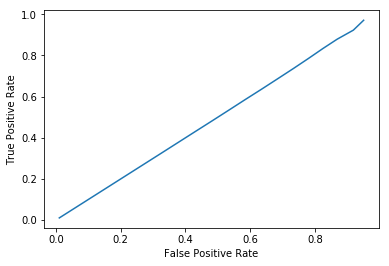

In [17]:
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

In [14]:
data_users.describe()

,average_stars,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_more,compliment_note,compliment_photos,compliment_plain,compliment_profile,compliment_writer,cool,fans,funny,review_count,useful,year
count,92381.000000,92381.000000,92381.000000,92381.000000,92381.000000,92381.000000,92381.000000,92381.000000,92381.000000,92381.000000,92381.000000,92381.000000,92381.000000,92381.000000,92381.000000,92381.000000,92381.000000,92381.000000
mean,3.559019,5.640803,0.310194,5.640803,3.748855,0.177894,0.582512,2.611922,1.876609,6.013931,0.425001,2.248677,40.669640,2.530250,31.681298,33.631807,70.635661,2013.552549
std,1.060362,133.675306,11.661069,133.675306,112.101491,9.290651,15.429126,44.738893,71.549861,125.363341,23.824390,45.181440,621.800074,25.105661,524.225249,137.028649,759.122721,2.514763
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2004.000000
25%,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,2012.000000
50%,3.730000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,6.000000,3.000000,2014.000000
75%,4.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,4.000000,18.000000,16.000000,2015.000000
max,5.000000,23733.000000,2401.000000,23733.000000,23891.000000,2261.000000,3575.000000,4901.000000,12732.000000,11579.000000,5660.000000,7022.000000,82128.000000,2383.000000,86122.000000,12390.000000,89418.000000,2018.000000
